In [120]:
#importing classes
import pandas as pd
import numpy as np
import pickle
import bilby as bi
from astropy import units as u
import matplotlib.pyplot as plt
from scipy import integrate
from scipy.optimize import curve_fit
from scipy.integrate import quad
from astropy.cosmology import Planck18,z_at_value
from scipy.optimize import curve_fit
from matplotlib import cm  # For color map
from scipy.stats import gaussian_kde
from scipy.signal import find_peaks
import multiprocessing
from scipy.interpolate import interp1d
from concurrent.futures import ThreadPoolExecutor
import emcee
from scipy.interpolate import RegularGridInterpolator
from scipy.optimize import minimize
import matplotlib.cm as cm
from matplotlib import rc
import time
from joblib import Parallel, delayed
from matplotlib.animation import FuncAnimation, FFMpegWriter
from collections import defaultdict
from scipy.stats import bootstrap
from scipy.ndimage import gaussian_filter1d
import corner
from scipy.stats import multivariate_normal
from scipy.fftpack import fft, ifft, fftfreq, fftshift

## Create redshift interpolant

In [289]:
# Define grid ranges
H0_min, H0_max, H0_steps = 40, 100, 256  # H0 in km/s/Mpc
D_L_min, D_L_max, D_L_steps = 1, 1e6, 2500  # D_L in Mpc

H0_values = np.linspace(H0_min, H0_max, H0_steps)
D_L_values = np.linspace(D_L_min, D_L_max, D_L_steps)

z_grid = np.zeros((H0_steps, D_L_steps))

In [290]:
def compute_z(i, j):
    H0 = H0_values[i]
    D_L = D_L_values[j]

    try:
        cosmo = Planck18.clone(H0=H0 * u.km / (u.Mpc * u.s))
        z = z_at_value(cosmo.luminosity_distance, D_L * u.Mpc)
        
        return (i, j, z)
    except Exception as e:
        print(f"Warning: H0={H0}, D_L={D_L} — {e}")
        return (i, j, np.nan)

# Flatten the grid and compute in parallel
results = Parallel(n_jobs=-1, verbose=5)(
    delayed(compute_z)(i, j)
    for i in range(len(H0_values))
    for j in range(len(D_L_values))
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 1616 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 5648 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 10832 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 17168 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done 24656 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done 33296 tasks      | elapsed:   24.6s
[Parallel(n_jobs=-1)]: Done 43088 tasks      | elapsed:   31.1s
[Parallel(n_jobs=-1)]: Done 54032 tasks      | elapsed:   38.8s
[Parallel(n_jobs=-1)]: Done 66128 tasks      | elapsed:   46.8s
[Parallel(n_jobs=-1)]: Done 79376 tasks      | elapsed:   55.8s
[Parallel(n_jobs=-1)]: Done 93776 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 109328 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 12603

In [292]:
# Define ranges for H0 and redshift
H0_values = np.linspace(40, 100, 256)  # H0 in km/s/Mpc

for i, j, z in results:
    z_grid[i, j] = z.value  # Axis 0: H0, 1: D_L

# Create the interpolant
redshift_interpolant = RegularGridInterpolator(
    (H0_values, D_L_values),
    z_grid,
    bounds_error=False,
    fill_value=np.nan
)

In [293]:
# Save the interpolant to a file
with open("redshift_interpolant.pkl", "wb") as f:
    pickle.dump(redshift_interpolant, f)

print("Interpolant saved to redshift_interpolant.pkl")


Interpolant saved to redshift_interpolant.pkl


In [294]:
with open("redshift_interpolant.pkl", "rb") as f:
    redshift_interpolant = pickle.load(f)

In [287]:
def analyze_mass_distance_relation_evol_iter_comb(luminosityDistances, log_mass_plus_log1pz, initial_guess=(100, 0, 0,0,0), d_num=100, width_fac=1.32):
    def compute_d_num(mass_cut_size):
        return ((mass_cut_size) // 100)  # Ensure d_num stays within a reasonable range
    d_num_low = d_num
    d_num_high = d_num
    for _ in range(3):  # Run the process twice
        # Define separate d_num for each cut

        # Define distance bins separately for low and high mass cuts
        d_bins_low = np.percentile(luminosityDistances, np.linspace(0, 100, num=d_num_low))
        d_bins_high = np.percentile(luminosityDistances, np.linspace(0, 100, num=d_num_high))

        # Track peaks and assign masks in a single loop
        peak_tracks = defaultdict(list)
        filtered_masks = {label: np.zeros_like(log_mass_plus_log1pz, dtype=bool) for label in ['low_mass', 'high_mass']}
        peak_group_id, previous_peaks = 0, []

        for i in range(len(d_bins_low) - 1):
            bin_mask = (d_bins_low[i] <= luminosityDistances) & (luminosityDistances < d_bins_low[i + 1])
            log_mass_bin, lum_dist_bin = log_mass_plus_log1pz[bin_mask], luminosityDistances[bin_mask]

            if len(log_mass_bin) > 3:
                kde = gaussian_kde(log_mass_bin)
                x_vals = np.linspace(log_mass_bin.min(), log_mass_bin.max(), 100)
                peaks = x_vals[find_peaks(kde(x_vals))[0]]
                errors = [np.std(log_mass_bin)] * len(peaks)
                mean_lum_dist = lum_dist_bin.mean()

                current_peaks = []
                for peak_value in peaks:
                    closest = min(previous_peaks, key=lambda p: abs(peak_value - p['value']), default=None)
                    if closest and abs(peak_value - closest['value']) < 0.2:
                        peak_tracks[closest['group']].append((mean_lum_dist, peak_value, errors[0]))
                        current_peaks.append({'value': peak_value, 'group': closest['group']})
                    else:
                        peak_tracks[peak_group_id].append((mean_lum_dist, peak_value, errors[0]))
                        current_peaks.append({'value': peak_value, 'group': peak_group_id})
                        peak_group_id += 1
                previous_peaks = current_peaks

                # Assign masks immediately
                for label, group in zip(['low_mass', 'high_mass'], list(peak_tracks.keys())[:2]):
                    distances, peak_values, _ = zip(*peak_tracks[group])
                    peak_value_bin = np.interp(mean_lum_dist, distances, peak_values)
                    peak_error_bin = np.std(log_mass_bin) / width_fac

                    within_range = np.where((log_mass_bin >= peak_value_bin - peak_error_bin) & 
                                            (log_mass_bin <= peak_value_bin + peak_error_bin))[0]
                    below, above = within_range[log_mass_bin[within_range] < peak_value_bin], \
                                   within_range[log_mass_bin[within_range] > peak_value_bin]

                    num_to_keep = min(len(below), len(above))
                    bin_peak_mask = np.zeros_like(log_mass_bin, dtype=bool)
                    bin_peak_mask[np.concatenate((below[:num_to_keep], above[:num_to_keep]))] = True
                    filtered_masks[label][bin_mask] = bin_peak_mask

        # Track peaks and assign masks in a single loop
        peak_tracks = defaultdict(list)
        filtered_masks_high = {label: np.zeros_like(log_mass_plus_log1pz, dtype=bool) for label in ['low_mass', 'high_mass']}
        peak_group_id, previous_peaks = 0, []
        
        for i in range(len(d_bins_high) - 1):
            bin_mask = (d_bins_high[i] <= luminosityDistances) & (luminosityDistances < d_bins_high[i + 1])
            log_mass_bin, lum_dist_bin = log_mass_plus_log1pz[bin_mask], luminosityDistances[bin_mask]

            if len(log_mass_bin) > 3:
                kde = gaussian_kde(log_mass_bin)
                x_vals = np.linspace(log_mass_bin.min(), log_mass_bin.max(), 100)
                peaks = x_vals[find_peaks(kde(x_vals))[0]]
                errors = [np.std(log_mass_bin)] * len(peaks)
                mean_lum_dist = lum_dist_bin.mean()

                current_peaks = []
                for peak_value in peaks:
                    closest = min(previous_peaks, key=lambda p: abs(peak_value - p['value']), default=None)
                    if closest and abs(peak_value - closest['value']) < 0.2:
                        peak_tracks[closest['group']].append((mean_lum_dist, peak_value, errors[0]))
                        current_peaks.append({'value': peak_value, 'group': closest['group']})
                    else:
                        peak_tracks[peak_group_id].append((mean_lum_dist, peak_value, errors[0]))
                        current_peaks.append({'value': peak_value, 'group': peak_group_id})
                        peak_group_id += 1
                previous_peaks = current_peaks

                # Assign masks immediately
                for label, group in zip(['low_mass', 'high_mass'], list(peak_tracks.keys())[:2]):
                    distances, peak_values, _ = zip(*peak_tracks[group])
                    peak_value_bin = np.interp(mean_lum_dist, distances, peak_values)
                    peak_error_bin = np.std(log_mass_bin) / width_fac

                    within_range = np.where((log_mass_bin >= peak_value_bin - peak_error_bin) & 
                                            (log_mass_bin <= peak_value_bin + peak_error_bin))[0]
                    below, above = within_range[log_mass_bin[within_range] < peak_value_bin], \
                                   within_range[log_mass_bin[within_range] > peak_value_bin]

                    num_to_keep = min(len(below), len(above))
                    bin_peak_mask = np.zeros_like(log_mass_bin, dtype=bool)
                    bin_peak_mask[np.concatenate((below[:num_to_keep], above[:num_to_keep]))] = True
                    filtered_masks_high[label][bin_mask] = bin_peak_mask

        # Extract filtered data
        mask_low, mask_high = filtered_masks['low_mass'], filtered_masks_high['high_mass']
        lum_dist_cut1, mass_cut1 = luminosityDistances[mask_low] * u.Mpc, log_mass_plus_log1pz[mask_low]
        lum_dist_cut2, mass_cut2 = luminosityDistances[mask_high] * u.Mpc, log_mass_plus_log1pz[mask_high]

        # Sort for consistency
        sort1, sort2 = np.argsort(lum_dist_cut1), np.argsort(lum_dist_cut2)
        lum_dist_cut1, mass_cut1 = lum_dist_cut1[sort1], mass_cut1[sort1]
        lum_dist_cut2, mass_cut2 = lum_dist_cut2[sort2], mass_cut2[sort2]

        # Adjust d_num separately for each cut
        d_num_low = compute_d_num(len(mass_cut1))
        d_num_high = compute_d_num(len(mass_cut2))

    # Perform the fitting
    fit = fit_and_optimize_evol_comb([lum_dist_cut1, lum_dist_cut2], [mass_cut1,mass_cut2], initial_guess)
    
    return fit, (lum_dist_cut1, mass_cut1), (lum_dist_cut2, mass_cut2)

def fit_and_optimize_evol_comb(luminosityDistances, log_mass_plus_log1pz, initial_guess):

    """
    Fit for H0, mass offset, and mass evolution slope (k).
    """
    result = minimize(
        objective_evol_comb,
        initial_guess,  # Initial guess for [H0, mass_offset, k]
        args=(luminosityDistances, log_mass_plus_log1pz, redshift_interpolant),
        bounds=[(40, 100), (5, 100), (-0.3, 1.4),(5, 100), (-1.4, 1.4)],  # Add bounds for k if needed
        method="L-BFGS-B"
    )
    
    if result.success:
        best_H0, best_mass_offset_low, best_k_low,best_mass_offset_high, best_k_high = result.x
    else:
        best_H0, best_mass_offset_low, best_k_low,best_mass_offset_high, best_k_high = None, None, None, None, None
    return best_H0, best_mass_offset_low, best_k_low,best_mass_offset_high, best_k_high

def objective_evol_comb(params, luminosityDistances, log_mass_plus_log1pz, interpolant):
    """
    Objective function to fit H0, mass offset, and mass evolution slope k, with weights.
    """
    H0, mass_offset_low, k_low,mass_offset_high, k_high = params

    lum_dist_cut1 = luminosityDistances[0]
    lum_dist_cut2 = luminosityDistances[1]

    mass_cut1 = log_mass_plus_log1pz[0]
    mass_cut2 = log_mass_plus_log1pz[1]

    # Prepare the input for the interpolant
    points_low = np.vstack((np.full_like(lum_dist_cut1.value, H0), lum_dist_cut1.value)).T  # Shape (N, 2)

    # Get interpolated redshifts
    redshifts_low = interpolant(points_low)

    # Prepare the input for the interpolant
    points_high = np.vstack((np.full_like(lum_dist_cut2.value, H0), lum_dist_cut2.value)).T  # Shape (N, 2)

    # Get interpolated redshifts
    redshifts_high = interpolant(points_high)
    
    # Handle NaNs (optional): Assign a high residual if any z is NaN
    if np.isnan(redshifts_low).any() or np.isnan(redshifts_high).any():
        return np.inf  # Penalize invalid z values

    # Compute the modeled log(1+z) + mass_offset with evolving mass peak
    modeled_log1pz_plus_logM_low = np.log10(mass_offset_low + k_low * redshifts_low) + np.log10(1 + redshifts_low)

    modeled_log1pz_plus_logM_high = np.log10(mass_offset_high + k_high * redshifts_high) + np.log10(1 + redshifts_high)

    # Calculate weighted residuals
    residuals_low = mass_cut1 - modeled_log1pz_plus_logM_low
    residuals_high = mass_cut2 - modeled_log1pz_plus_logM_high

    #weighted_residuals = weights * (residuals ** 2)  # Apply weights

    return np.sum(residuals_low**2)+np.sum(residuals_high**2)  # Sum of squared residuals

def massDensity_evol(mu_1_base, sigma_1, f_p1, alpha_1, m_min, m_b, 
                     mu_2_base, sigma_2, f_p2, alpha_2, delta_m, m_max, redshifts, ev_1, ev_2):
    
    ev_1 = ev_1*u.Msun   
    ev_2 = ev_2*u.Msun    

    N = 1000
    m_1 = np.linspace(7, m_max.value, N) * u.Msun
    m_1_value = m_1.value  # Remove unnecessary unit operations in loops

    # Precompute redshift-dependent mu values
    mu_1_z = (mu_1_base + ev_1 * redshifts[:, None]) * u.Msun
    mu_2_z = (mu_2_base + ev_2 * redshifts[:, None]) * u.Msun

    # Precompute logical masks
    mask1 = m_1_value < m_min.value
    mask2 = (m_1_value >= m_min.value) & (m_1_value < m_b.value)
    mask3 = (m_1_value >= m_b.value) & (m_1_value < m_max.value)

    # Initialize gamma array
    gamma = np.zeros((len(redshifts), N))

    # Compute gamma in one step using broadcasting
    gamma[:, mask1] = np.exp(-((m_1_value[mask1] - m_min.value) ** 2 / (2 * delta_m.value ** 2))) \
                      * (m_1_value[mask1] / m_b.value) ** alpha_1
    gamma[:, mask2] = (m_1_value[mask2] / m_b.value) ** alpha_1
    gamma[:, mask3] = (m_1_value[mask3] / m_b.value) ** alpha_2

    # Normalize gamma only once per redshift
    integral_gamma = integrate.simpson(gamma, x=m_1_value, axis=1)[:, None]
    gamma /= integral_gamma  # Broadcasting normalization

    # Compute Gaussian distributions using broadcasting
    N_1 = (f_p1 / (sigma_1.value * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((m_1_value - mu_1_z.value) / sigma_1.value) ** 2)
    N_2 = (f_p2 / (sigma_2.value * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((m_1_value - mu_2_z.value) / sigma_2.value) ** 2)

    # Compute probability density
    p_values = (N_1 + N_2 + (1 - f_p1 - f_p2) * gamma) * u.Msun

    return p_values, m_1

# Adjust sampling function to handle redshift evolution
def inverseTransformSamplingWithEvolution(cdf_list, m_1, redshifts, num_samples):
    samples = []
    for i, z in enumerate(redshifts):
        uniform_samples = np.random.uniform(0, 1, num_samples // len(redshifts))  # Uniform samples
        inverse_samples = np.interp(uniform_samples, cdf_list[i], m_1.value)  # Inverse transform
        samples.append(inverse_samples)
    return np.concatenate(samples) * u.Msun

def fit_and_plot_evol(H0, mass_offset,k, luminosityDistances, log_mass_plus_log1pz,interpolant, label_suffix, color_obs, color_fit):
    # Plot the observed data with the specified color
    

    # Generate a range of distances and corresponding redshifts for the interpolant
    distance_samples = np.linspace(
        luminosityDistances.min().value, 
        luminosityDistances.max().value, 
        1000
    )    


    # Prepare the input for the interpolant
    points = np.vstack((np.full_like(distance_samples, H0), distance_samples)).T  # Shape (N, 2)
    
    # Get interpolated redshifts
    redshifts = interpolant(points)


    modeled_values = []
    for i in range(len(distance_samples)):
    #redshift = distance_to_redshift_interp(dist)
        log1pz = np.log10(1 + redshifts[i])
    
        #if mass_offset + k * redshifts[i] > 0:
        modeled_values.append(log1pz + np.log10(mass_offset + k * redshifts[i]))


    plt.scatter(
        luminosityDistances, 
        log_mass_plus_log1pz, 
        s=3, 
        color=color_obs, 
        label=f"Observed Data ({label_suffix})"
    )
    
    # Plot the fitted curve with the specified color and line style
    plt.plot(
        distance_samples, 
        modeled_values, 
        linestyle="--", 
        color=color_fit, 
        label=f'Best fit H0 ({label_suffix}) = {H0:.4f}'
    )

# Define the prior for redshift with uniform comoving volume
def generate_redshift_samples(min_redshift, max_redshift, num_samples, cosmology=Planck18):
    # Set up the uniform comoving volume prior
    redshift_prior = bi.gw.prior.UniformComovingVolume(
        minimum=min_redshift, 
        maximum=max_redshift, 
        cosmology=cosmology, 
        name="redshift"
    )

    # Sample redshifts
    redshift_samples = redshift_prior.sample(num_samples)
    return redshift_samples

# Function to compute the cumulative density function
def cumulativeDensity(p, m_1):
    cdf = np.cumsum(p)  # Compute the CDF
    cdf /= cdf[-1]      # Normalize the CDF
    return cdf

# Define the function to add observational error with constant log distance scatter
def add_observational_error(luminosityDistances, log_mass_plus_log1pz, 
                            mass_error_fraction=0.1, log_distance_scatter=0.05):
    """
    Add observational error to redshifted masses and luminosity distances.

    Parameters:
    - luminosityDistances (array): Array of luminosity distances.
    - log_mass_plus_log1pz (array): Array of log(M) + log(1+z).
    - mass_error_fraction (float): Fractional error for non-logged masses (default 10%).
    - log_distance_scatter (float): Constant scatter in log(luminosity distance) (default 0.05).

    Returns:
    - perturbed_luminosityDistances: Luminosity distances with added error.
    - perturbed_log_mass_plus_log1pz: log(M) + log(1+z) with added error.
    """
    num_samples = len(luminosityDistances)

    # Convert log(M) + log(1+z) back to non-logged mass * (1 + z)
    non_logged_mass_plus_1pz = 10**log_mass_plus_log1pz

    # Compute standard deviations for the mass errors
    mass_error_std = mass_error_fraction * non_logged_mass_plus_1pz

    # Apply constant scatter in log(luminosity distance)
    log_luminosity_distances = np.log10(luminosityDistances)
    perturbed_log_luminosity_distances = log_luminosity_distances + np.random.normal(
        loc=0, scale=log_distance_scatter, size=num_samples
    )
    
    perturbed_luminosityDistances = 10**perturbed_log_luminosity_distances  # Convert back to linear scale

    # Perturb the mass * (1 + z) values
    perturbed_non_logged_mass_plus_1pz = non_logged_mass_plus_1pz + np.random.normal(
        loc=0, scale=mass_error_std, size=num_samples
    )

    # Convert back to log(M) + log(1+z)
    perturbed_log_mass_plus_log1pz = np.log10(perturbed_non_logged_mass_plus_1pz)

    return perturbed_luminosityDistances, perturbed_log_mass_plus_log1pz


## Parameters to generate BBH mass distribution

In [267]:
# Parameters with astropy units
mu_1 = 10.0 * u.Msun
mu_2 = 33.4 * u.Msun
sigma_1 = 1.1 * u.Msun
sigma_2 = 4.2 * u.Msun
f_p1 = 0.75
f_p2 = 0.07

f_p1 = 0.75
f_p2 = 0.07

alpha_1 = -2.7
alpha_2 = -4.2
m_min = 12.9 * u.Msun
delta_m = 0.6 * u.Msun
m_b = 42.7 * u.Msun
m_max = 100 * u.Msun
num_samples = int(5e4)
k_1 = 0.0
k_2= 1
mass_error_fraction=0.1
log_distance_scatter=0.05

## Generate samples

In [268]:
# Simulations
redshifts = generate_redshift_samples(0.0, 10.0, num_samples)
p_values, mass = massDensity_evol(mu_1, sigma_1, f_p1, alpha_1, m_min, m_b, 
                                          mu_2, sigma_2, f_p2, alpha_2, delta_m, m_max, 
                                          redshifts, k_1, k_2)
cdf_list = [cumulativeDensity(p, mass) for p in p_values]
massSamples = inverseTransformSamplingWithEvolution(cdf_list, mass, redshifts, num_samples)
log_mass_plus_log1pz = np.log10(massSamples.value * (1 + redshifts))
        #luminosityDistances = luminosity_distance_interp(redshifts)
luminosityDistances = Planck18.luminosity_distance(redshifts).value

        # Add observational errors
luminosityDistances, log_mass_plus_log1pz = add_observational_error(
            luminosityDistances, log_mass_plus_log1pz, 
            mass_error_fraction=0, 
            log_distance_scatter=0
        )

## Data reduction / calibration

In [269]:
mask = np.where((luminosityDistances < 1e10) & (luminosityDistances > 0000))
filtered_luminosityDistances = luminosityDistances[mask]
filtered_log_mass_plus_log1pz = log_mass_plus_log1pz[mask]
filtered_redshifts = redshifts[mask]

## Fitting + Plotting

66.95516186389706
0.010288544872886588
10.09198983717192
0.9535142088970572
32.83563230879329


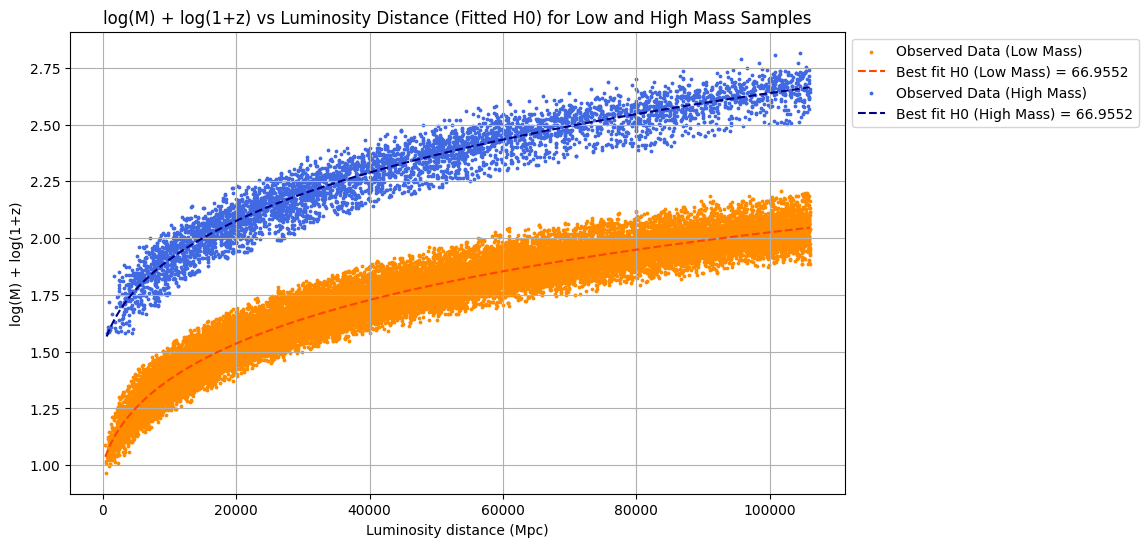

In [295]:
# Use the analyze_mass_distance_relation function and plot results
results, data_cut1, data_cut2 = analyze_mass_distance_relation_evol_iter_comb(
    filtered_luminosityDistances, filtered_log_mass_plus_log1pz,d_num=100,width_fac=1.3
)

# Unpack the results
best_H0, best_mass_offset_low_mass,best_k_low_mass,best_mass_offset_high_mass,best_k_high_mass = results

luminosityDistances_cut1, log_mass_plus_log1pz_cut1 = data_cut1
luminosityDistances_cut2, log_mass_plus_log1pz_cut2 = data_cut2

print(best_H0)
print(best_k_low_mass)
print(best_mass_offset_low_mass)
print(best_k_high_mass)
print(best_mass_offset_high_mass)

# Plotting code
plt.figure(figsize=(10, 6))
fit_and_plot_evol(best_H0, best_mass_offset_low_mass,best_k_low_mass,luminosityDistances_cut1, log_mass_plus_log1pz_cut1, redshift_interpolant,"Low Mass", color_obs="darkorange", color_fit="orangered")
fit_and_plot_evol(best_H0, best_mass_offset_high_mass,best_k_high_mass,luminosityDistances_cut2, log_mass_plus_log1pz_cut2, redshift_interpolant,"High Mass", color_obs="royalblue", color_fit="navy")
plt.xlabel("Luminosity distance (Mpc)")
plt.ylabel("log(M) + log(1+z)")
plt.title("log(M) + log(1+z) vs Luminosity Distance (Fitted H0) for Low and High Mass Samples")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.grid(True)
plt.show()

## Omega matter fitting

In [254]:
def fit_and_optimize_evol_comb_m(luminosityDistances, log_mass_plus_log1pz, initial_guess):

    """
    Fit for H0, mass offset, and mass evolution slope (k).
    """
    result = minimize(
        objective_evol_comb_m,
        initial_guess,  # Initial guess for [H0, mass_offset, k]
        args=(luminosityDistances, log_mass_plus_log1pz, redshift_interpolant_m),
        bounds=[(40, 100), (5, 100), (-0.3, 1.4),(5, 100), (-1.4, 1.4),(0.05,0.95)],  # Add bounds for k if needed
        method="L-BFGS-B"
    )
    
    if result.success:
        best_H0, best_mass_offset_low, best_k_low,best_mass_offset_high, best_k_high,best_Om_m = result.x
    else:
        best_H0, best_mass_offset_low, best_k_low,best_mass_offset_high, best_k_high,best_Om_m = None, None, None, None, None,None
    return best_H0, best_mass_offset_low, best_k_low,best_mass_offset_high, best_k_high,best_Om_m

def objective_evol_comb_m(params, luminosityDistances, log_mass_plus_log1pz, interpolant):
    """
    Objective function to fit H0, mass offset, and mass evolution slope k, with weights.
    """
    H0, mass_offset_low, k_low,mass_offset_high, k_high, Om_m = params

    lum_dist_cut1 = luminosityDistances[0]
    lum_dist_cut2 = luminosityDistances[1]

    mass_cut1 = log_mass_plus_log1pz[0]
    mass_cut2 = log_mass_plus_log1pz[1]

    # Prepare the input for the interpolant
    points_low = np.vstack((
        np.full_like(lum_dist_cut1.value, H0),      # (N,) array of H0
        lum_dist_cut1.value,                         # (N,) array of distances
        np.full_like(lum_dist_cut1.value, Om_m)    # (N,) array of Om_m
    )).T 

    # Get interpolated redshifts
    redshifts_low = interpolant(points_low)

    # Prepare the input for the interpolant
    points_high = np.vstack((
        np.full_like(lum_dist_cut2.value, H0),      # (N,) array of H0
        lum_dist_cut2.value,                         # (N,) array of distances
        np.full_like(lum_dist_cut2.value, Om_m)    # (N,) array of Om_m
    )).T 

    # Get interpolated redshifts
    redshifts_high = interpolant(points_high)

    
    # Handle NaNs (optional): Assign a high residual if any z is NaN
    if np.isnan(redshifts_low).any() or np.isnan(redshifts_high).any():
        return np.inf  # Penalize invalid z values

    # Compute the modeled log(1+z) + mass_offset with evolving mass peak
    modeled_log1pz_plus_logM_low = np.log10(mass_offset_low + k_low * redshifts_low) + np.log10(1 + redshifts_low)

    modeled_log1pz_plus_logM_high = np.log10(mass_offset_high + k_high * redshifts_high) + np.log10(1 + redshifts_high)


    # Calculate weighted residuals
    residuals_low = mass_cut1 - modeled_log1pz_plus_logM_low
    residuals_high = mass_cut2 - modeled_log1pz_plus_logM_high

    #weighted_residuals = weights * (residuals ** 2)  # Apply weights

    # --- Optional prior on Omega_m (Gaussian) ---
    Om_m_prior_mean = 0.30966     # or your preferred prior mean
    Om_m_prior_sigma = 0.02   # or your preferred uncertainty

    prior_penalty = ((Om_m - Om_m_prior_mean) ** 2) / (Om_m_prior_sigma ** 2)

    return np.sum(residuals_low**2) + np.sum(residuals_high**2) + prior_penalty*15

def analyze_mass_distance_relation_evol_iter_comb_m(luminosityDistances, log_mass_plus_log1pz, initial_guess=(100, 0, 0,0,0,0.2), d_num=100, width_fac=1.32):
    def compute_d_num(mass_cut_size):
        return ((mass_cut_size) // 100)  # Ensure d_num stays within a reasonable range
    d_num_low = d_num
    d_num_high = d_num
    for _ in range(3):  # Run the process twice
        # Define separate d_num for each cut

        # Define distance bins separately for low and high mass cuts
        d_bins_low = np.percentile(luminosityDistances, np.linspace(0, 100, num=d_num_low))
        d_bins_high = np.percentile(luminosityDistances, np.linspace(0, 100, num=d_num_high))

        # Track peaks and assign masks in a single loop
        peak_tracks = defaultdict(list)
        filtered_masks = {label: np.zeros_like(log_mass_plus_log1pz, dtype=bool) for label in ['low_mass', 'high_mass']}
        peak_group_id, previous_peaks = 0, []

        for i in range(len(d_bins_low) - 1):
            bin_mask = (d_bins_low[i] <= luminosityDistances) & (luminosityDistances < d_bins_low[i + 1])
            log_mass_bin, lum_dist_bin = log_mass_plus_log1pz[bin_mask], luminosityDistances[bin_mask]

            if len(log_mass_bin) > 3:
                kde = gaussian_kde(log_mass_bin)
                x_vals = np.linspace(log_mass_bin.min(), log_mass_bin.max(), 100)
                peaks = x_vals[find_peaks(kde(x_vals))[0]]
                errors = [np.std(log_mass_bin)] * len(peaks)
                mean_lum_dist = lum_dist_bin.mean()

                current_peaks = []
                for peak_value in peaks:
                    closest = min(previous_peaks, key=lambda p: abs(peak_value - p['value']), default=None)
                    if closest and abs(peak_value - closest['value']) < 0.2:
                        peak_tracks[closest['group']].append((mean_lum_dist, peak_value, errors[0]))
                        current_peaks.append({'value': peak_value, 'group': closest['group']})
                    else:
                        peak_tracks[peak_group_id].append((mean_lum_dist, peak_value, errors[0]))
                        current_peaks.append({'value': peak_value, 'group': peak_group_id})
                        peak_group_id += 1
                previous_peaks = current_peaks

                # Assign masks immediately
                for label, group in zip(['low_mass', 'high_mass'], list(peak_tracks.keys())[:2]):
                    distances, peak_values, _ = zip(*peak_tracks[group])
                    peak_value_bin = np.interp(mean_lum_dist, distances, peak_values)
                    peak_error_bin = np.std(log_mass_bin) / width_fac

                    within_range = np.where((log_mass_bin >= peak_value_bin - peak_error_bin) & 
                                            (log_mass_bin <= peak_value_bin + peak_error_bin))[0]
                    below, above = within_range[log_mass_bin[within_range] < peak_value_bin], \
                                   within_range[log_mass_bin[within_range] > peak_value_bin]

                    num_to_keep = min(len(below), len(above))
                    bin_peak_mask = np.zeros_like(log_mass_bin, dtype=bool)
                    bin_peak_mask[np.concatenate((below[:num_to_keep], above[:num_to_keep]))] = True
                    filtered_masks[label][bin_mask] = bin_peak_mask

        # Track peaks and assign masks in a single loop
        peak_tracks = defaultdict(list)
        filtered_masks_high = {label: np.zeros_like(log_mass_plus_log1pz, dtype=bool) for label in ['low_mass', 'high_mass']}
        peak_group_id, previous_peaks = 0, []
        
        for i in range(len(d_bins_high) - 1):
            bin_mask = (d_bins_high[i] <= luminosityDistances) & (luminosityDistances < d_bins_high[i + 1])
            log_mass_bin, lum_dist_bin = log_mass_plus_log1pz[bin_mask], luminosityDistances[bin_mask]

            if len(log_mass_bin) > 3:
                kde = gaussian_kde(log_mass_bin)
                x_vals = np.linspace(log_mass_bin.min(), log_mass_bin.max(), 100)
                peaks = x_vals[find_peaks(kde(x_vals))[0]]
                errors = [np.std(log_mass_bin)] * len(peaks)
                mean_lum_dist = lum_dist_bin.mean()

                current_peaks = []
                for peak_value in peaks:
                    closest = min(previous_peaks, key=lambda p: abs(peak_value - p['value']), default=None)
                    if closest and abs(peak_value - closest['value']) < 0.2:
                        peak_tracks[closest['group']].append((mean_lum_dist, peak_value, errors[0]))
                        current_peaks.append({'value': peak_value, 'group': closest['group']})
                    else:
                        peak_tracks[peak_group_id].append((mean_lum_dist, peak_value, errors[0]))
                        current_peaks.append({'value': peak_value, 'group': peak_group_id})
                        peak_group_id += 1
                previous_peaks = current_peaks

                # Assign masks immediately
                for label, group in zip(['low_mass', 'high_mass'], list(peak_tracks.keys())[:2]):
                    distances, peak_values, _ = zip(*peak_tracks[group])
                    peak_value_bin = np.interp(mean_lum_dist, distances, peak_values)
                    peak_error_bin = np.std(log_mass_bin) / width_fac

                    within_range = np.where((log_mass_bin >= peak_value_bin - peak_error_bin) & 
                                            (log_mass_bin <= peak_value_bin + peak_error_bin))[0]
                    below, above = within_range[log_mass_bin[within_range] < peak_value_bin], \
                                   within_range[log_mass_bin[within_range] > peak_value_bin]

                    num_to_keep = min(len(below), len(above))
                    bin_peak_mask = np.zeros_like(log_mass_bin, dtype=bool)
                    bin_peak_mask[np.concatenate((below[:num_to_keep], above[:num_to_keep]))] = True
                    filtered_masks_high[label][bin_mask] = bin_peak_mask

        # Extract filtered data
        mask_low, mask_high = filtered_masks['low_mass'], filtered_masks_high['high_mass']
        lum_dist_cut1, mass_cut1 = luminosityDistances[mask_low] * u.Mpc, log_mass_plus_log1pz[mask_low]
        lum_dist_cut2, mass_cut2 = luminosityDistances[mask_high] * u.Mpc, log_mass_plus_log1pz[mask_high]

        # Sort for consistency
        sort1, sort2 = np.argsort(lum_dist_cut1), np.argsort(lum_dist_cut2)
        lum_dist_cut1, mass_cut1 = lum_dist_cut1[sort1], mass_cut1[sort1]
        lum_dist_cut2, mass_cut2 = lum_dist_cut2[sort2], mass_cut2[sort2]

        # Adjust d_num separately for each cut
        d_num_low = compute_d_num(len(mass_cut1))
        d_num_high = compute_d_num(len(mass_cut2))

    # Perform the fitting
    fit = fit_and_optimize_evol_comb_m([lum_dist_cut1, lum_dist_cut2], [mass_cut1,mass_cut2], initial_guess)

    return fit, (lum_dist_cut1, mass_cut1), (lum_dist_cut2, mass_cut2)

def fit_and_plot_evol_m(H0, mass_offset,k,Om_m, luminosityDistances, log_mass_plus_log1pz,interpolant_m, label_suffix, color_obs, color_fit):
    # Plot the observed data with the specified color
    

    # Generate a range of distances and corresponding redshifts for the interpolant
    distance_samples = np.linspace(
        luminosityDistances.min().value, 
        luminosityDistances.max().value, 
        1000
    )    

     # Prepare the input for the interpolant
    points = np.vstack((
            np.full_like(distance_samples, H0),      # (N,) array of H0
            distance_samples,                         # (N,) array of distances
            np.full_like(distance_samples, Om_m)    # (N,) array of Om_m
        )).T 
    
    # Get interpolated redshifts
    redshifts = interpolant_m(points)

    modeled_values = []
    for i in range(len(distance_samples)):
    #redshift = distance_to_redshift_interp(dist)
        log1pz = np.log10(1 + redshifts[i])
    
        #if mass_offset + k * redshifts[i] > 0:
        modeled_values.append(log1pz + np.log10(mass_offset + k * redshifts[i]))


    plt.scatter(
        luminosityDistances, 
        log_mass_plus_log1pz, 
        s=3, 
        color=color_obs, 
        label=f"Observed Data ({label_suffix})"
    )
    
    # Plot the fitted curve with the specified color and line style
    plt.plot(
        distance_samples, 
        modeled_values, 
        linestyle="--", 
        color=color_fit, 
        label=f'Best fit H0 ({label_suffix}) = {H0:.4f}'
    )

In [ ]:
# Parameter grids
H0_values = np.linspace(40, 100, 256)
D_L_values = np.linspace(1, 1_000_000, 2500)
omega_m_values = np.linspace(0.05, 0.95, 100)

# Preallocate output
z_grid_m = np.full((len(H0_values), len(D_L_values),len(omega_m_values)),0)

def compute_z(i, j, k):
    H0 = H0_values[i]
    D_L = D_L_values[j]
    Om0 = omega_m_values[k]

    try:
        cosmo = Planck18.clone(H0=H0 * u.km / (u.Mpc * u.s), Om0=Om0)
        z = z_at_value(cosmo.luminosity_distance, D_L * u.Mpc)
        
        return (i, j, k, z)
    except Exception as e:
        print(f"Warning: H0={H0}, Om0={Om0}, D_L={D_L} — {e}")
        return (i, j, k, np.nan)

# Flatten the grid and compute in parallel
results = Parallel(n_jobs=-1, verbose=5)(
    delayed(compute_z)(i, j, k)
    for i in range(len(H0_values))
    for j in range(len(D_L_values))
    for k in range(len(omega_m_values))

)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 4208 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 12272 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 22640 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 35312 tasks      | elapsed:   17.9s
[Parallel(n_jobs=-1)]: Done 50288 tasks      | elapsed:   26.8s
[Parallel(n_jobs=-1)]: Done 67568 tasks      | elapsed:   37.7s
[Parallel(n_jobs=-1)]: Done 87152 tasks      | elapsed:   52.5s


In [245]:
for i, j, k, z in results:
    z_grid_m[i, j, k] = z.value  # Axis 0: H0, 1: D_L, 2: Om0

# Create the interpolant
redshift_interpolant_m = RegularGridInterpolator(
    (H0_values, D_L_values, omega_m_values),
    z_grid_m,
    bounds_error=False,
    fill_value=np.nan
)

# Save the interpolant to a file
with open("redshift_interpolant_m.pkl", "wb") as f:
    pickle.dump(redshift_interpolant_m, f)

print("Interpolant saved to redshift_interpolant_m.pkl")

with open("redshift_interpolant_m.pkl", "rb") as f:
    redshift_interpolant_m = pickle.load(f)

Interpolant saved to redshift_interpolant_m.pkl


## Parameters to generate BBH mass distribution

In [246]:
# Parameters with astropy units
mu_1 = 10.0 * u.Msun
mu_2 = 33.4 * u.Msun
sigma_1 = 1.1 * u.Msun
sigma_2 = 4.2 * u.Msun
f_p1 = 0.75
f_p2 = 0.07

f_p1 = 0.75
f_p2 = 0.07

alpha_1 = -2.7
alpha_2 = -4.2
m_min = 12.9 * u.Msun
delta_m = 0.6 * u.Msun
m_b = 42.7 * u.Msun
m_max = 100 * u.Msun
num_samples = int(5e4)
k_1 = 0.0
k_2= 1
mass_error_fraction=0.1
log_distance_scatter=0.05

## Generate samples

In [247]:
# Simulations
redshifts = generate_redshift_samples(0.0, 10.0, num_samples)
p_values, mass = massDensity_evol(mu_1, sigma_1, f_p1, alpha_1, m_min, m_b, 
                                          mu_2, sigma_2, f_p2, alpha_2, delta_m, m_max, 
                                          redshifts, k_1, k_2)
cdf_list = [cumulativeDensity(p, mass) for p in p_values]
massSamples = inverseTransformSamplingWithEvolution(cdf_list, mass, redshifts, num_samples)
log_mass_plus_log1pz = np.log10(massSamples.value * (1 + redshifts))
        #luminosityDistances = luminosity_distance_interp(redshifts)
luminosityDistances = Planck18.luminosity_distance(redshifts).value

        # Add observational errors
luminosityDistances, log_mass_plus_log1pz = add_observational_error(
            luminosityDistances, log_mass_plus_log1pz, 
            mass_error_fraction=0, 
            log_distance_scatter=0
        )

## Data reduction / calibration

In [248]:
mask = np.where((luminosityDistances < 1e10) & (luminosityDistances > 0000))
filtered_luminosityDistances = luminosityDistances[mask]
filtered_log_mass_plus_log1pz = log_mass_plus_log1pz[mask]
filtered_redshifts = redshifts[mask]

## Fitting + Plotting

In [258]:
# Use the analyze_mass_distance_relation function and plot results
results, data_cut1, data_cut2 = analyze_mass_distance_relation_evol_iter_comb_m(
    filtered_luminosityDistances, filtered_log_mass_plus_log1pz,d_num=100,width_fac=1.3)

# Unpack the results
best_H0, best_mass_offset_low_mass,best_k_low_mass,best_mass_offset_high_mass,best_k_high_mass,best_om_m = results

luminosityDistances_cut1, log_mass_plus_log1pz_cut1 = data_cut1
luminosityDistances_cut2, log_mass_plus_log1pz_cut2 = data_cut2

print(best_H0)
print(best_k_low_mass)
print(best_mass_offset_low_mass)
print(best_k_high_mass)
print(best_mass_offset_high_mass)
print(best_om_m)

# Plotting code
plt.figure(figsize=(10, 6))
fit_and_plot_evol(best_H0, best_mass_offset_low_mass,best_k_low_mass,luminosityDistances_cut1, log_mass_plus_log1pz_cut1, redshift_interpolant,"Low Mass", color_obs="darkorange", color_fit="orangered")
fit_and_plot_evol(best_H0, best_mass_offset_high_mass,best_k_high_mass,luminosityDistances_cut2, log_mass_plus_log1pz_cut2, redshift_interpolant,"High Mass", color_obs="royalblue", color_fit="navy")
plt.xlabel("Luminosity distance (Mpc)")
plt.ylabel("log(M) + log(1+z)")
plt.title("log(M) + log(1+z) vs Luminosity Distance (Fitted H0) for Low and High Mass Samples")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.grid(True)
plt.show()

# Plotting code
plt.figure(figsize=(10, 6))
fit_and_plot_evol_m(best_H0, best_mass_offset_low_mass,best_k_low_mass,best_om_m,luminosityDistances_cut1, log_mass_plus_log1pz_cut1, redshift_interpolant_m,"Low Mass", color_obs="darkorange", color_fit="orangered")
fit_and_plot_evol_m(best_H0, best_mass_offset_high_mass,best_k_high_mass,best_om_m,luminosityDistances_cut2, log_mass_plus_log1pz_cut2, redshift_interpolant_m,"High Mass", color_obs="royalblue", color_fit="navy")
plt.xlabel("Luminosity distance (Mpc)")
plt.ylabel("log(M) + log(1+z)")
plt.title("log(M) + log(1+z) vs Luminosity Distance (Fitted H0) for Low and High Mass Samples")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.grid(True)
plt.show()

99.36314570212336
-0.2411441465804119
10.246659903705657
-0.36133589357251555
34.58288267436734
0.3045454556254977


ValueError: The requested sample points xi have dimension 2 but this RegularGridInterpolator has dimension 3

<Figure size 1000x600 with 0 Axes>

ValueError: The requested sample points xi have dimension 2 but this RegularGridInterpolator has dimension 3

<Figure size 1000x600 with 0 Axes>

In [221]:
# Prepare the input for the interpolant
points_low = np.vstack((
        np.full_like(luminosityDistances, 67.66),      # (N,) array of H0
        luminosityDistances,                     # (N,) array of distances
        np.full_like(luminosityDistances, 0.30966)    # (N,) array of Om_m
    )).T 

    # Get interpolated redshifts
redshifts_low = redshift_interpolant_m(points_low)

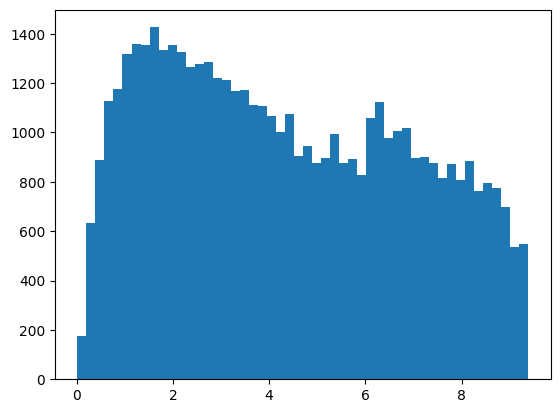

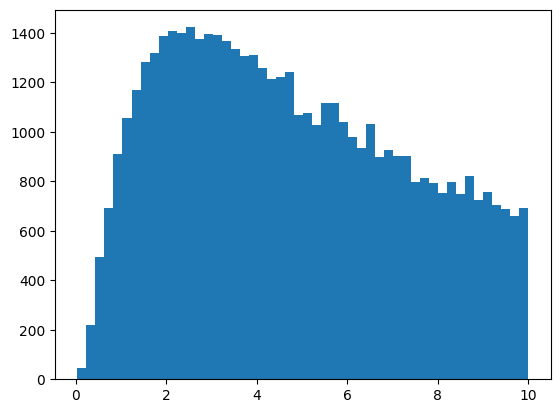

0.30966


In [223]:
plt.hist(redshifts_low,bins=50)
plt.show()
plt.hist(redshifts,bins=50)
plt.show()

print(Planck18.Om0)